
# *Exploration of Taxi Trip Fares in the San Francisco Bay Area*

In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
taxi_data = Table.read_table("SF_taxi_data.csv")

### Relationship Between Fares and Distance

According to the SFMTA fare calculation table, <br>
$Fare(x) \geq 3.5 + 0.55 × (5x − 1)$ <br>
We will analyze how this model compares to the actual relationship between fares and distance using real data.

In [3]:
predicted_fare = 3.5 + 0.55 * (5 * taxi_data.column("dist (miles)") - 1)
actual_fare = taxi_data.column("fare ($)")
least_squared_error = sum((actual_fare - predicted_fare) ** 2) / len(actual_fare)
least_squared_error

51.760001810791501

Since the least squared error between the actual and predicted fares is significantly over 0, we can see that the model is not an accurate indicator of the actual relationship between fares and distance.

### Analysis of Trips Related to SFO

In order to split up the total taxi trips to trips that include SFO and trips that do not include SFO, let us divide the taxi_data table into two tables that fit the criteria.

In [4]:
sfo_taz = taxi_data.group("deptaz").sort("count", descending=True).column("deptaz").item(0)
sfo_labeled_table = taxi_data.with_column("sfo", np.logical_or(taxi_data.column("deptaz") == np.full(taxi_data.num_rows, sfo_taz), taxi_data.column("arrtaz") == np.full(taxi_data.num_rows, sfo_taz)))
sfo_trips = sfo_labeled_table.where("sfo", True).drop("sfo")
no_sfo_trips = sfo_labeled_table.where("sfo", False).drop("sfo")

Let us analyze the differences between trips that include SFO and trips that do not by looking at the distances and fares.

In [5]:
print("Mean distance for sfo trips : ", np.mean(sfo_trips.column("dist (miles)")))
print("Mean distance for non-sfo trips : ", np.mean(no_sfo_trips.column("dist (miles)")))
print("Mean fare for sfo trips : ", np.mean(sfo_trips.column("fare ($)")))
print("Mean fare for non-sfo trips : ", np.mean(no_sfo_trips.column("fare ($)")))

Mean distance for sfo trips :  13.6399973334
Mean distance for non-sfo trips :  2.14582874527
Mean fare for sfo trips :  49.0883790447
Mean fare for non-sfo trips :  12.3978968537


From these means, we can see that the distances for trips including SFO are on average much bigger than other trips, hence the average fare is also higher. This logically makes sense because SFO is quite far from most hotspots in the Bay Area.

### Linear Regression of Travel Distance vs. Extra Cost (PART 3)

In [17]:
import pandas as pd
import seaborn as sns
sns.set()

In [50]:
taxi = taxi_data.to_df()
taxi.head()

,id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,0,9/1/12 0:11,9/1/12 0:20,13.20,1,-122.413540,37.802683,-122.421277,37.785395,38,30,1.980835
1,1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.419700,37.786090,-122.435217,37.762177,30,94,2.402241
2,2,9/1/12 0:45,9/1/12 0:49,9.00,1,-122.415120,37.774672,-122.407657,37.782615,10,11,0.479348
3,3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419392,37.806622,-122.415393,37.778115,40,10,2.122408
4,4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.429722,37.797790,-122.418060,37.789032,45,32,1.038070


In [51]:
taxi.shape

(50001, 12)

In [52]:
# taking out outliers
taxi_clean = taxi[(taxi["num"] == 1) & (taxi["fare ($)"] >= 3.5)]
taxi_clean.shape

(46408, 12)

In [70]:
# calculating base fare, taking out more outliers
taxi_clean["base fare"] = 3.5 + 0.55 * (5 * taxi_clean["dist (miles)"] - 1)
taxi_clean["extra fare"] = taxi_clean["fare ($)"] - taxi_clean["base fare"]
taxi_clean = taxi_clean[(taxi_clean['extra fare'] >= 0) 
                        & (taxi_clean['dist (miles)'] >= 0)]
taxi_clean.head()

,id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles),base fare,extra fare,dep dt,arr dt
0,0,9/1/12 0:11,9/1/12 0:20,13.20,1,-122.413540,37.802683,-122.421277,37.785395,38,30,1.980835,8.397297,4.802703,2012-09-01 00:11:00,2012-09-01 00:20:00
1,1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.419700,37.786090,-122.435217,37.762177,30,94,2.402241,9.556163,1.093837,2012-09-01 00:23:00,2012-09-01 00:31:00
2,2,9/1/12 0:45,9/1/12 0:49,9.00,1,-122.415120,37.774672,-122.407657,37.782615,10,11,0.479348,4.268208,4.731792,2012-09-01 00:45:00,2012-09-01 00:49:00
4,4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.429722,37.797790,-122.418060,37.789032,45,32,1.038070,5.804693,1.545307,2012-09-01 01:09:00,2012-09-01 01:13:00
5,5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433323,37.784148,-122.411398,37.786965,77,7,0.960851,5.592340,6.157660,2012-09-01 01:40:00,2012-09-01 01:52:00


In [74]:
taxi_clean['dep dt'] = pd.to_datetime(taxi_clean['departure time'], format="%m/%d/%y %H:%M")
taxi_clean['arr dt'] = pd.to_datetime(taxi_clean['arrival time'], format="%m/%d/%y %H:%M")
taxi_clean['dur'] = (taxi_clean["arr dt"] - taxi_clean['dep dt']) / np.timedelta64(1, 'm')
taxi_clean = taxi_clean[taxi_clean['dur'] >= 0]
taxi_clean.head()

,id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles),base fare,extra fare,dep dt,arr dt,dur
0,0,9/1/12 0:11,9/1/12 0:20,13.20,1,-122.413540,37.802683,-122.421277,37.785395,38,30,1.980835,8.397297,4.802703,2012-09-01 00:11:00,2012-09-01 00:20:00,9.0
1,1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.419700,37.786090,-122.435217,37.762177,30,94,2.402241,9.556163,1.093837,2012-09-01 00:23:00,2012-09-01 00:31:00,8.0
2,2,9/1/12 0:45,9/1/12 0:49,9.00,1,-122.415120,37.774672,-122.407657,37.782615,10,11,0.479348,4.268208,4.731792,2012-09-01 00:45:00,2012-09-01 00:49:00,4.0
4,4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.429722,37.797790,-122.418060,37.789032,45,32,1.038070,5.804693,1.545307,2012-09-01 01:09:00,2012-09-01 01:13:00,4.0
5,5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433323,37.784148,-122.411398,37.786965,77,7,0.960851,5.592340,6.157660,2012-09-01 01:40:00,2012-09-01 01:52:00,12.0


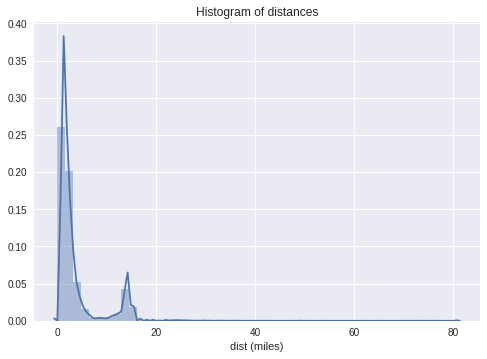

In [64]:
sns.distplot(taxi_clean["dist (miles)"])
plt.title("Histogram of distances")

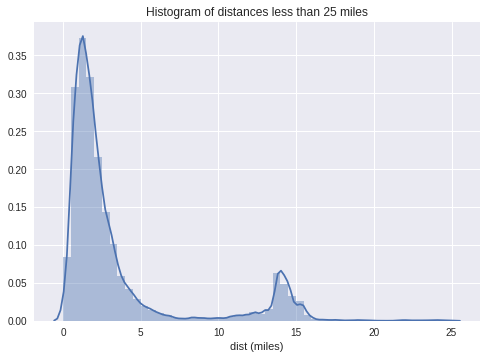

In [66]:
sns.distplot(taxi_clean[taxi_clean["dist (miles)"] < 25]['dist (miles)'])
plt.title("Histogram of distances less than 25 miles")

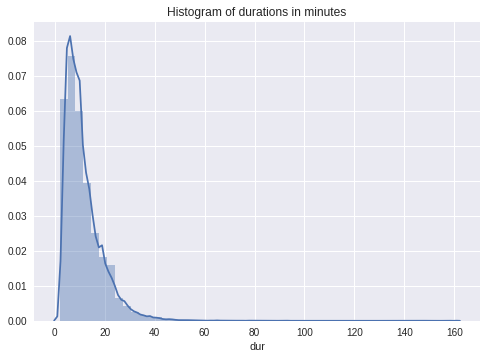

In [76]:
sns.distplot(taxi_clean['dur'])
plt.title('Histogram of durations in minutes')

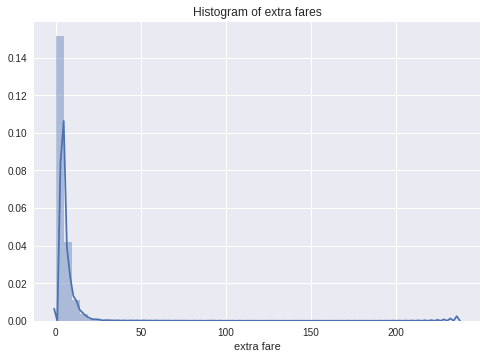

In [68]:
sns.distplot(taxi_clean["extra fare"])
plt.title("Histogram of extra fares")

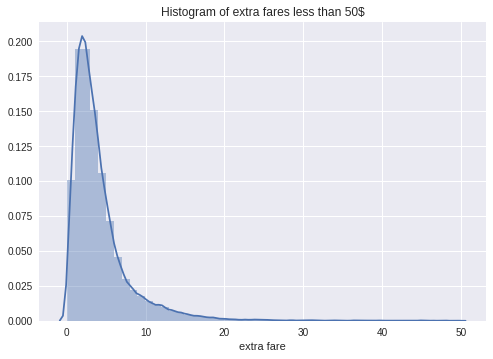

In [69]:
sns.distplot(taxi_clean[taxi_clean["extra fare"]< 50]['extra fare']) 
plt.title("Histogram of extra fares less than 50$")

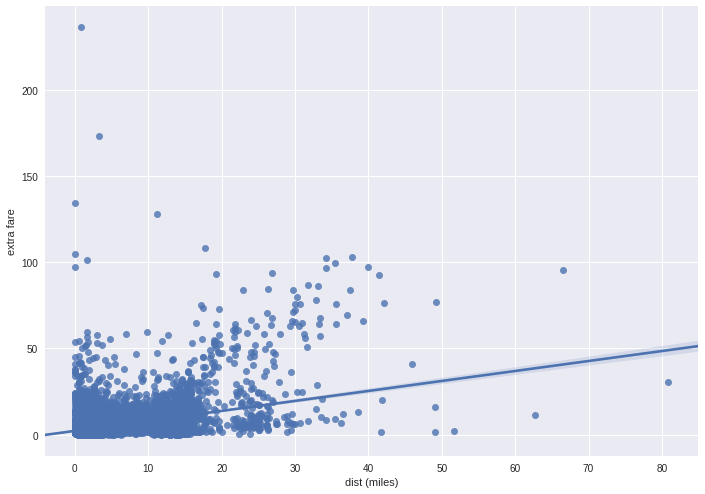

In [57]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.regplot(x='dist (miles)', y='extra fare', 
              data=taxi_clean[taxi_clean['dep dt'].dt.day < 11], ax=ax)

In [95]:
from sklearn import linear_model as lm
from sklearn.metrics import r2_score

(25.779085767070296, 0.27002534675722911)

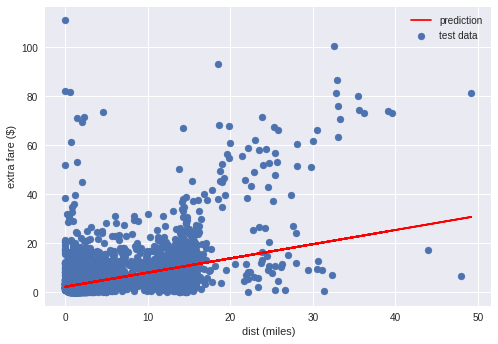

In [107]:
clf = lm.LinearRegression()
train = taxi_clean[taxi_clean['dep dt'].dt.day < 11]
test = taxi_clean[taxi_clean['dep dt'].dt.day >= 11]
clf.fit(train[['dist (miles)']], train['extra fare'])
preds = clf.predict(test[['dist (miles)']])
plt.scatter(test['dist (miles)'], test['extra fare'], label='test data')
plt.plot(test['dist (miles)'], preds, color='r', label='prediction')
plt.legend()
plt.xlabel("dist (miles)")
plt.ylabel("extra fare ($)");
# mean squared error, r2 score
np.mean((preds - test['extra fare'])**2), r2_score(test['extra fare'], preds)

(19.289441207441815, 0.45378966174837343)

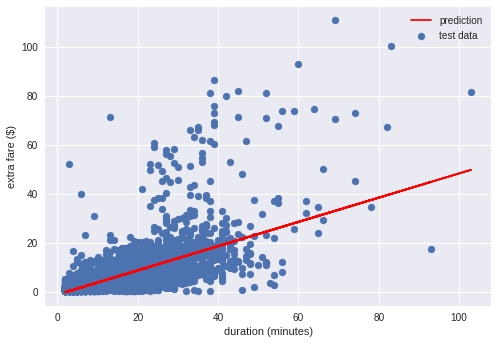

In [106]:
clf = lm.LinearRegression()
train = taxi_clean[taxi_clean['dep dt'].dt.day < 11]
test = taxi_clean[taxi_clean['dep dt'].dt.day >= 11]
clf.fit(train[['dur']], train['extra fare'])
preds = clf.predict(test[['dur']])
plt.scatter(test['dur'], test['extra fare'], label='test data')
plt.plot(test['dur'], preds, color='r', label='prediction')
plt.legend()
plt.xlabel("duration (minutes)")
plt.ylabel("extra fare ($)");
# mean squared error, r2 score
np.mean((preds - test['extra fare'])**2), r2_score(test['extra fare'], preds)

In [143]:
clf = lm.LinearRegression()
train = taxi_clean[taxi_clean['dep dt'].dt.day < 11]
test = taxi_clean[taxi_clean['dep dt'].dt.day >= 11]
clf.fit(train[['dur', 'dist (miles)']], train['extra fare'])
preds = clf.predict(test[['dur', 'dist (miles)']])
np.mean((preds - test['extra fare'])**2), r2_score(test['extra fare'], preds)

(19.34617097054257, 0.45218327083434784)

In [144]:
clf.coef_


array([ 0.51995583, -0.05552932])

In [110]:
taxi_clean['deptaz'].value_counts().head()

239    3434
7      1861
41     1393
12     1280
5      1129
Name: deptaz, dtype: int64

In [122]:
taxi_clean.head().iloc[0].loc['deptaz'] == 3

False

In [123]:
sfotaz = 239
def label(row):
    if row.loc['deptaz'] == sfotaz:
        return 'depart from sfo area'
    elif row.loc['arrtaz'] == sfotaz:
        return 'arriving to sfo area'
    else:
        return 'not sfo'
taxi_clean['label'] = taxi_clean.apply(label, axis=1)
taxi_clean.head()

,id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles),base fare,extra fare,dep dt,arr dt,dur,label
0,0,9/1/12 0:11,9/1/12 0:20,13.20,1,-122.413540,37.802683,-122.421277,37.785395,38,30,1.980835,8.397297,4.802703,2012-09-01 00:11:00,2012-09-01 00:20:00,9.0,not sfo
1,1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.419700,37.786090,-122.435217,37.762177,30,94,2.402241,9.556163,1.093837,2012-09-01 00:23:00,2012-09-01 00:31:00,8.0,not sfo
2,2,9/1/12 0:45,9/1/12 0:49,9.00,1,-122.415120,37.774672,-122.407657,37.782615,10,11,0.479348,4.268208,4.731792,2012-09-01 00:45:00,2012-09-01 00:49:00,4.0,not sfo
4,4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.429722,37.797790,-122.418060,37.789032,45,32,1.038070,5.804693,1.545307,2012-09-01 01:09:00,2012-09-01 01:13:00,4.0,not sfo
5,5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433323,37.784148,-122.411398,37.786965,77,7,0.960851,5.592340,6.157660,2012-09-01 01:40:00,2012-09-01 01:52:00,12.0,not sfo


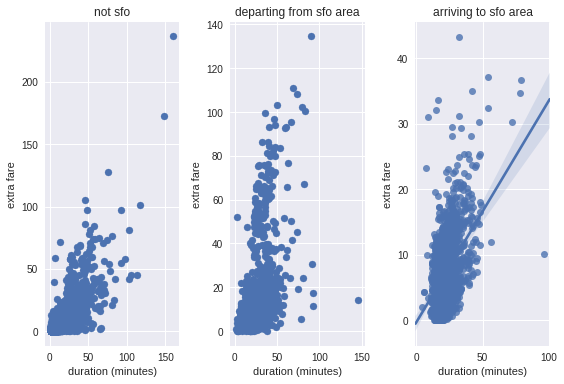

In [152]:
plt.subplot(1, 3, 1)
data = taxi_clean[taxi_clean['label'] == 'not sfo']
plt.scatter(data['dur'], data['extra fare'])
plt.xlabel('duration (minutes)')
plt.ylabel("extra fare")
plt.title("not sfo")
plt.subplot(1, 3, 2)
data = taxi_clean[taxi_clean['label'] == 'depart from sfo area']
plt.scatter(data['dur'], data['extra fare'])
plt.xlabel('duration (minutes)')
plt.ylabel("extra fare")
plt.title("departing from sfo area")
ax=plt.subplot(1, 3, 3)
data = taxi_clean[taxi_clean['label'] == 'arriving to sfo area']
sns.regplot(data['dur'], data['extra fare'], ax=ax)
plt.xlabel('duration (minutes)')
plt.ylabel("extra fare")
plt.title("arriving to sfo area")
plt.tight_layout()

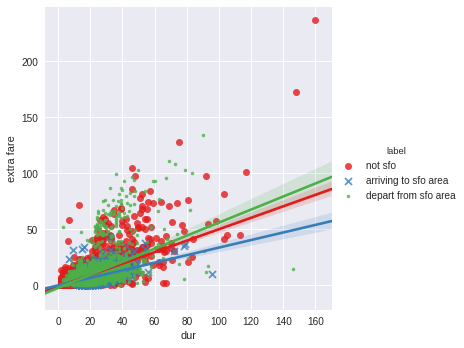

In [154]:
sns.lmplot(x='dur', y="extra fare", hue="label", data=taxi_clean,
           markers=["o", "x", '.'], palette="Set1");

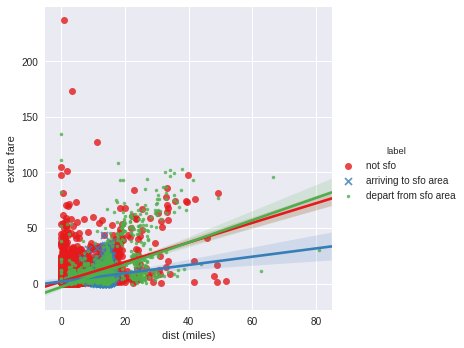

In [155]:
sns.lmplot(x='dist (miles)', y="extra fare", hue="label", data=taxi_clean,
           markers=["o", "x", '.'], palette="Set1");

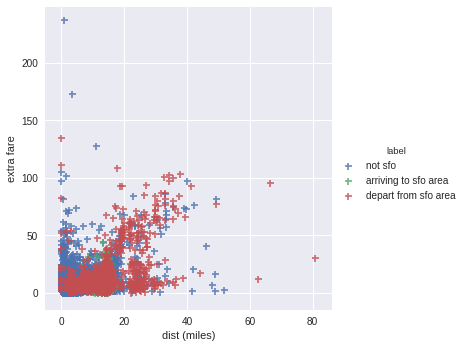

In [158]:
from sklearn import preprocessing

In [170]:
data = taxi_clean[taxi_clean['label'] == 'not sfo']
data = data[['dur', 'dist (miles)', 'extra fare', 'dep dt']]
train = data[data['dep dt'].dt.day < 11]
test = data[data['dep dt'].dt.day >= 11]
s = preprocessing.StandardScaler()
clf = lm.LinearRegression()
clf.fit(s.fit_transform(train[['dur', 'dist (miles)']]), train['extra fare'])
clf.coef_, clf.score(s.fit_transform(test[['dur', 'dist (miles)']]), test['extra fare'])

(array([ 3.47888003, -0.3575633 ]), 0.51519078514164462)

In [172]:
data = taxi_clean[taxi_clean['label'] == 'depart from sfo area']
data = data[['dur', 'dist (miles)', 'extra fare', 'dep dt']]
train = data[data['dep dt'].dt.day < 11]
test = data[data['dep dt'].dt.day >= 11]
s = preprocessing.StandardScaler()
clf = lm.LinearRegression()
clf.fit(s.fit_transform(train[['dur', 'dist (miles)']]), train['extra fare'])
clf.coef_, clf.score(s.fit_transform(test[['dur', 'dist (miles)']]), test['extra fare'])

(array([ 3.83121534,  2.53265095]), 0.23743792785353279)

In [171]:
data = taxi_clean[taxi_clean['label'] == 'arriving to sfo area']
data = data[['dur', 'dist (miles)', 'extra fare', 'dep dt']]
train = data[data['dep dt'].dt.day < 11]
test = data[data['dep dt'].dt.day >= 11]
s = preprocessing.StandardScaler()
clf = lm.LinearRegression()
clf.fit(s.fit_transform(train[['dur', 'dist (miles)']]), train['extra fare'])
clf.coef_, clf.score(s.fit_transform(test[['dur', 'dist (miles)']]), test['extra fare'])

(array([ 2.59113973, -0.77223631]), 0.15739089734253398)

In [6]:
# Analysis here

### Linear Regression of Travel Duration vs. Extra Cost

In [7]:
# Analysis here

### Linear Regression vs. K-Nearest Neighbors

In [ ]:
# Analysis here